
# [ParslFest 2025](https://parsl-project.org/parslfest/parslfest2025.html)

# [Accelerating QMCpy Notebook Tests with Parsl](https://www.figma.com/slides/k7EUosssNluMihkYTLuh1F/Parsl-Testbook-Speedup?node-id=1-37&t=WnKcu2QYO8JXvtpP-0)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/parsl_fest_2025.ipynb)

Joshua Herman and Sou-Cheng Choi, QMCPy Developers

Aug 28 -- 29, 2025

Updated: Nov 27, 2025

**Requirements**:

* QMCPy: `pip install qmcpy==2.1`
* LaTeX: `sudo apt update && sudo apt install -y texlive-full`
* testbook : `pip install testbook==0.4.2`
* Parsl: `pip install parsl==2025.7.28`

This notebook can be run interactively or in command line mode. To run in command line mode, use:
```bash
    conda activate qmcpy && cd demos && jupyter execute --kernel_name qmcpy parsl_fest_2025.ipynb
```

Our presentation slides for ParslFest are available at [Figma](https://www.figma.com/slides/k7EUosssNluMihkYTLuh1F/Parsl-Testbook-Speedup?node-id=174-95&t=t3jENVMltXWwdLdb-0).

In [1]:
try:
    import qmcpy as qp
except ModuleNotFoundError:
    !pip install -q qmcpy

try:
    import testbook as tb
except ModuleNotFoundError:
    !pip install -q testbook

In [2]:
import sys
import os
import time
import inspect
import parsl as pl
from parsl.configs.htex_local import config
import matplotlib.pyplot as plt

## 1. Sequential Execution

In [3]:
start_time = time.time()
!(cd .. && make booktests_no_docker)
sequential_time = time.time() - start_time

rm -fr demos/.ipynb_checkpoints/*checkpoint.ipynb && \
find demos -name '*.ipynb' | while read nb; do \
	base=$(basename "$nb" .ipynb); \
	test_base=$(echo "$base" | sed 's/[-.]/_/g'); \
	if [ "$base" != "parsl_fest_2025" ] && ! ls test/booktests/tb_"$test_base".py > /dev/null 2>&1; then \
		echo "    Missing test for: $nb -> Expected: test/booktests/tb_$test_base.py"; \
	fi; \
done
Total notebooks:  33
Total test files: 37

Generating missing booktest files...
cd test/booktests/ && python generate_test.py --check-missing
No missing test files found.
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done

Notebook tests
pip install -q -e ".[test]"  && \
set -e && \
cd test/booktests/ && \
if [ -z "" ]; then \
	PYTHONWARNINGS="ignore::UserWarning,ignore::DeprecationWarning,ignore::FutureWarning,ignore::ImportWarning" \
	python -W ignore -m coverage run --append --source=../../qmcpy/ -m unittest discover -s . -p "*.py" -v --fail

## 2. Parsl

1. Install and Configure Parsl
2. Run the tests in parallel with Parsl

### 2.1 Install and Configure Parsl

### 2.2 Create a Parsl Test Runner

In [3]:
try:
    import parsl as pl
except ModuleNotFoundError:
    !pip install -q parsl
    
config.max_workers = 8  
if not pl.config:
    pl.load(config)
    print("Parsl loaded with memory limits")
else:
    print("Parsl already configured")

Parsl already configured


In [4]:
# Ensure the path to the booktests directory is included
sys.path.append(os.path.join(os.getcwd(), '..', 'test', 'booktests'))

In [5]:
import parsl_test_runner
import inspect

# See only functions
print("Functions:")
functions = inspect.getmembers(parsl_test_runner, inspect.isfunction)
for name, func in functions:
    print(f"- {name}")
print("\n" + "="*50)

# Get help on specific function
print("Help for execute_parallel_tests:")
help(parsl_test_runner.execute_parallel_tests)

Functions:
- bash_app
- execute_parallel_tests
- generate_summary_report
- main

Help for execute_parallel_tests:
Help on function execute_parallel_tests in module parsl_test_runner:

execute_parallel_tests()
    Execute all testbook tests in parallel using Parsl



### 2.3 Run the Notebooks in Parallel with Parsl

In [6]:
start_time2 = time.time()
!(cd .. && make booktests_parallel_no_docker)
parallel_time = time.time() - start_time2

rm -fr demos/.ipynb_checkpoints/*checkpoint.ipynb && \
find demos -name '*.ipynb' | while read nb; do \
	base=$(basename "$nb" .ipynb); \
	test_base=$(echo "$base" | sed 's/[-.]/_/g'); \
	if [ "$base" != "parsl_fest_2025" ] && ! ls test/booktests/tb_"$test_base".py > /dev/null 2>&1; then \
		echo "    Missing test for: $nb -> Expected: test/booktests/tb_$test_base.py"; \
	fi; \
done
Total notebooks:  33
Total test files: 37

Generating missing booktest files...
cd test/booktests/ && python generate_test.py --check-missing
No missing test files found.
chmod +x scripts/find_local_only_folders.sh > /dev/null 2>&1
for f in ; do \
	rm -f "$f"; > /dev/null 2>&1; \
done

Notebook tests with Parsl
pip install -q -e ".[test]"  && \
cd test/booktests/ && \
rm -fr *.eps *.jpg *.pdf *.png *.part *.txt *.log && rm -fr logs && rm -fr runinfo prob_failure_gp_ci_plots && \
PYTHONWARNINGS="ignore::UserWarning,ignore::DeprecationWarning,ignore::FutureWarning,ignore::ImportWarning" \
python parsl_test_ru

In [7]:
sequential_time = 1237.113
parallel_time = 408.294
speedup = sequential_time / parallel_time
print(f"Sequential time:  {sequential_time:.2f} seconds")
print(f"Parallel time:    {parallel_time:.2f} seconds")
print(f"Speedup by Parsl: {speedup:.2f}")

Sequential time:  1237.11 seconds
Parallel time:    408.29 seconds
Speedup by Parsl: 3.03


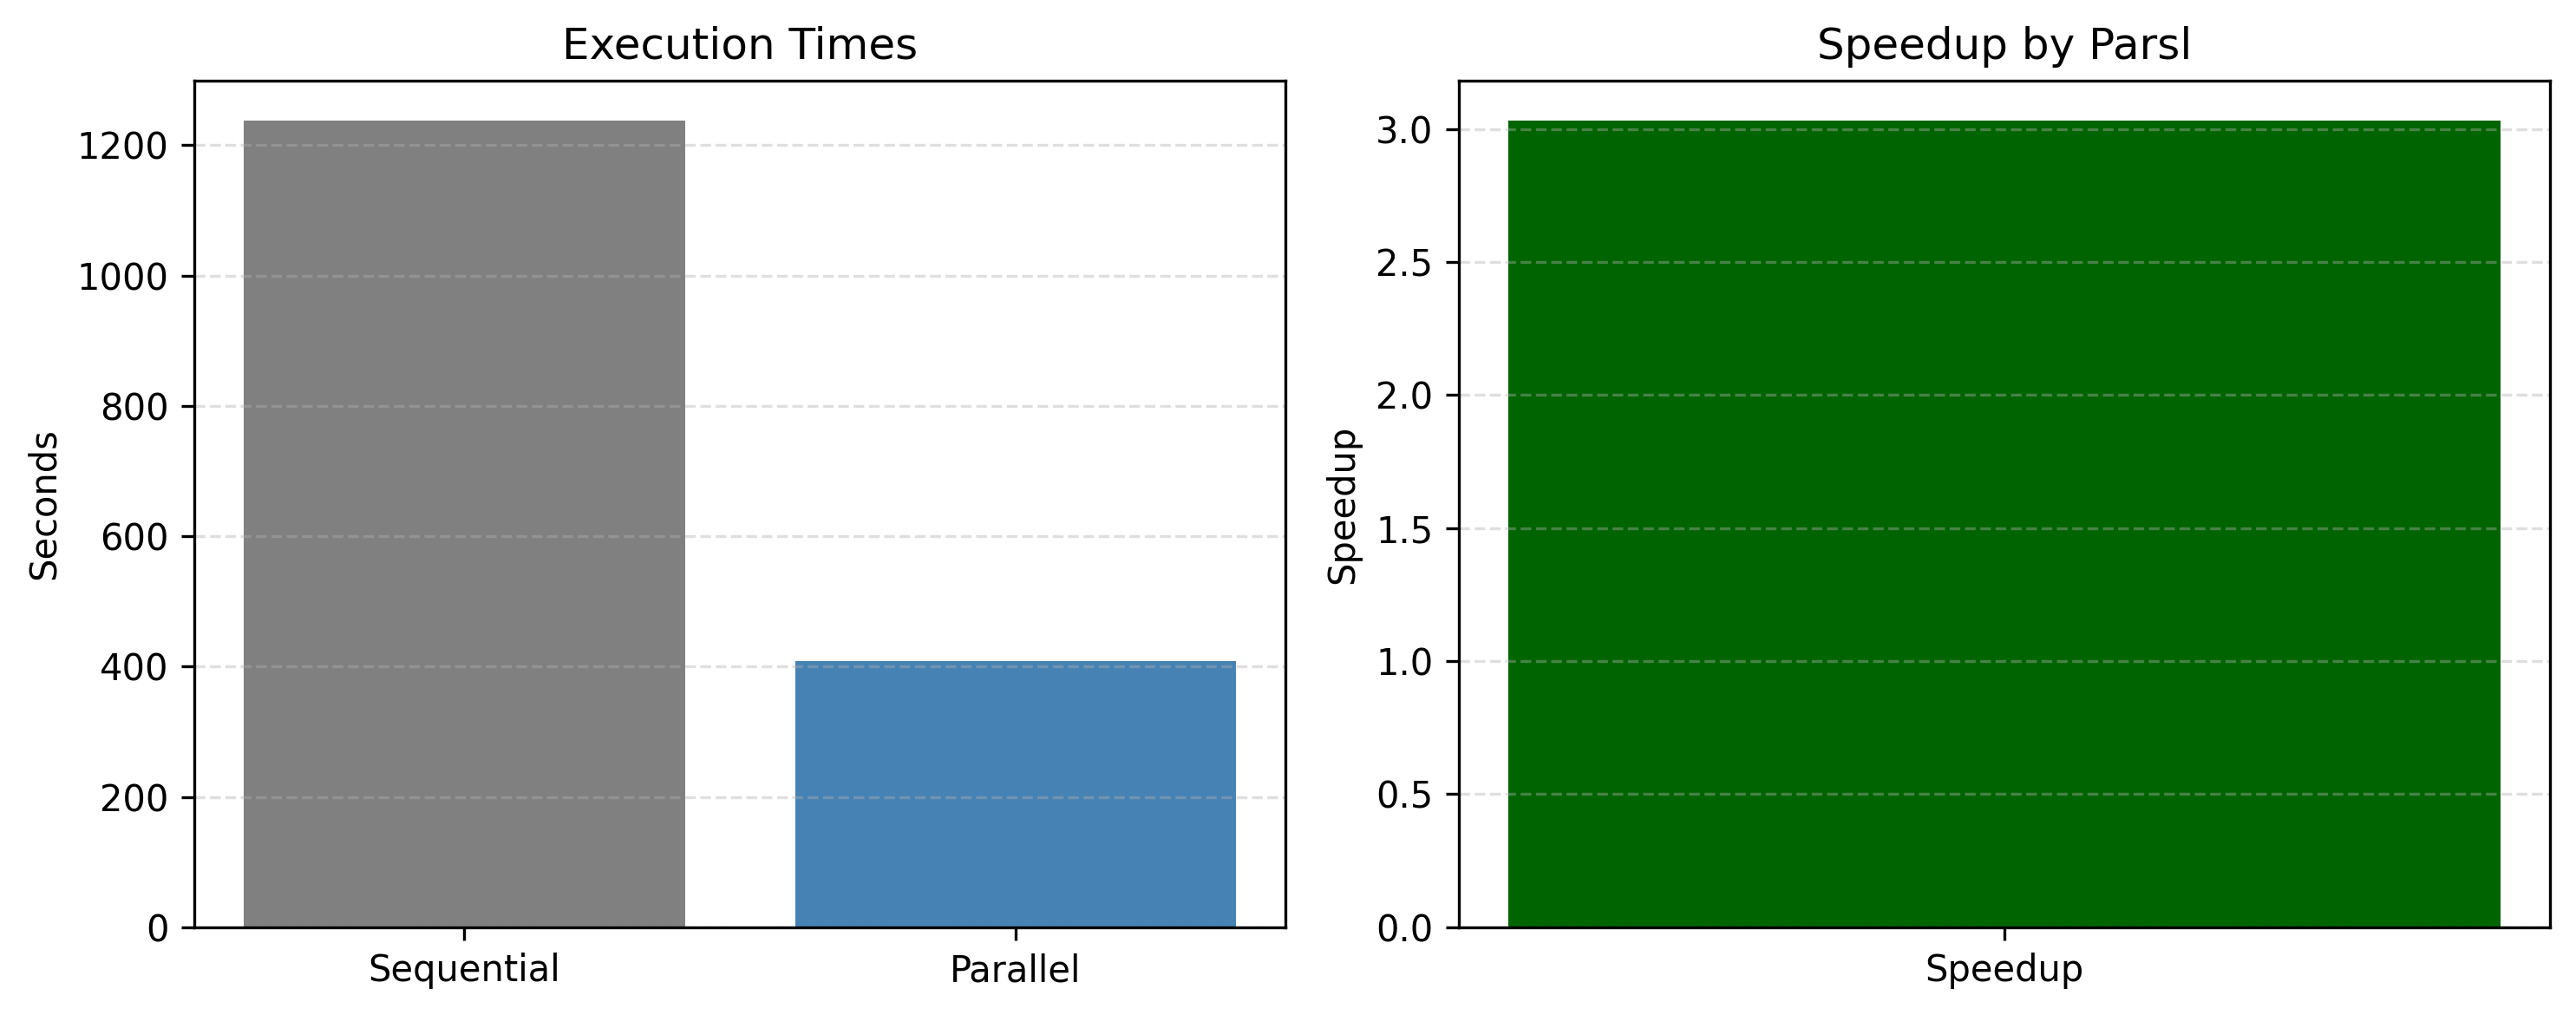

In [9]:
speedup = sequential_time / parallel_time

fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=300)

# --- Panel 1: Times ---
axes[0].bar(["Sequential", "Parallel"], [sequential_time, parallel_time], color=["gray", "steelblue"])
axes[0].set_title("Execution Times")
axes[0].set_ylabel("Seconds")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# --- Panel 2: Speedup ---
axes[1].bar(["Speedup"], [speedup], color="darkgreen")
axes[1].set_title("Speedup by Parsl")
axes[1].set_ylabel("Speedup")
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
# --- Save as PNG ---
plt.savefig("parsl_speedup.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
import platform

if platform.system().lower() == 'linux':
    !uname -a
    !nproc --all
    !awk '/MemTotal/ {printf "%.2f GB\n", $2/1024/1024}' /proc/meminfo

Linux codespaces-6c6933 6.8.0-1030-azure #35~22.04.1-Ubuntu SMP Mon May 26 18:08:30 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
16
62.80 GB
